# Project Title
# Report on U.S. Health Insurance Marketplace 

## Instruction

### The datasets I used in this report contain data on health and dental plans offered to individuals and small businesses through the US Health Insurance Marketplace. This data was originally prepared and released by the Centers for Medicare & Medicaid Services (CMS), which is part of the U.S. Department of Health and Human Services (HHS). In this report I try to find some useful information to support the CMS work. You can watch a short video to get to know about CMS's work, mission, and vision. Please find the data dictionary for this report in the attached document.

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo('Kahh9MO8lYE')

#### Make a summary to introduce our dataset background by Python. (NLP)

In [2]:
import os
import sys
import json
#import feedparser
import requests
import pandas as pd
from nltk import clean_html
import urllib2
from bs4 import BeautifulSoup as bs

massey_proxies = {
  "http": "http://alb-cache.massey.ac.nz/",
  "https": "http://alb-cache.massey.ac.nz/",
}

In [3]:
import nltk

In [4]:
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [5]:
from IPython.core.display import HTML
HTML("<iframe src=https://www.cms.gov/cciio/resources/data-resources/marketplace-puf.html width=1000 height=350></iframe>")

In [6]:
HTML_PAGE = 'https://www.cms.gov/cciio/resources/data-resources/marketplace-puf.html'
response = requests.get(HTML_PAGE)
page = response.content

#### Clean text:

In [7]:
bs_object = bs(page, "lxml")  
raw = bs_object.get_text()
start = raw.find('The Centers for Medicare')
end = raw.find(' formulary information')
cleaned = raw[start : end + len(' formulary information')]
cleaned_article = cleaned.replace('\n', '')
cleaned_str = cleaned_article.encode('ascii','ignore')
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer('\w+')
cleaned_str[:1000]

'The Centers for Medicare & Medicaid Services (CMS) Center for Consumer Information and Insurance Oversight (CCIIO) is committed to increasing transparency in the Health Insurance Marketplace. While health plan information including benefits, copayments, premiums, and geographic coverage is publically available on Healthcare.gov, CMS has also released downloadable public use files (PUFs) so that researchers and other stakeholders can more easily access Marketplace data.The Health Insurance Marketplace Public Use Files (Marketplace PUFs) are available for plan years 2014 through 2017 to support timely benefit and rate analysis. It is important to note that the 2017 Marketplace PUFs will be updated regularly to reflect the plan data that consumers will see when shopping for a Marketplace Qualified Health Plan (QHP). Data for the 2017 Marketplace PUFs were imported to CMS systems onDecember 8, 2016.The Marketplace PUFs include plan and issuer level information for certified Qualified Heal

#### Text summarization 

In [8]:
import sys
import json
import nltk
import numpy

N = 50  # Number of words to consider
CLUSTER_THRESHOLD = 5  # Distance between words to consider
TOP_SENTENCES = 3  # Number of sentences to return for a "top n" summary

# Approach taken from "The Automatic Creation of Literature Abstracts" by H.P. Luhn

def _score_sentences(sentences, important_words):
    scores = []
    sentence_idx = -1

    for s in [nltk.tokenize.word_tokenize(s) for s in sentences]:

        sentence_idx += 1
        word_idx = []

        # For each word in the word list...
        for w in important_words:
            try:
                # Compute an index for where any important words occur in the sentence
                word_idx.append(s.index(w))
            except ValueError, e: # w not in this particular sentence
                pass

        word_idx.sort()

        # It is possible that some sentences may not contain any important words at all
        if len(word_idx)== 0: continue

        # Using the word index, compute clusters by using a max distance threshold
        # for any two consecutive words

        clusters = []
        cluster = [word_idx[0]]
        i = 1
        while i < len(word_idx):
            if word_idx[i] - word_idx[i - 1] < CLUSTER_THRESHOLD:
                cluster.append(word_idx[i])
            else:
                clusters.append(cluster[:])
                cluster = [word_idx[i]]
            i += 1
        clusters.append(cluster)

        # Score each cluster. The max score for any given cluster is the score 
        # for the sentence

        max_cluster_score = 0
        for c in clusters:
            significant_words_in_cluster = len(c)
            total_words_in_cluster = c[-1] - c[0] + 1
            score = 1.0 * significant_words_in_cluster \
                * significant_words_in_cluster / total_words_in_cluster

            if score > max_cluster_score:
                max_cluster_score = score

        scores.append((sentence_idx, score))

    return scores

In [9]:
def summarize(txt):
    sentences = [s for s in nltk.tokenize.sent_tokenize(txt)]
    normalized_sentences = [s.lower() for s in sentences]

    words = [w.lower() for sentence in normalized_sentences for w in
             nltk.tokenize.word_tokenize(sentence)]

    fdist = nltk.FreqDist(words)

    top_n_words = [w[0] for w in fdist.items() 
            if w[0] not in nltk.corpus.stopwords.words('english')][:N]

    scored_sentences = _score_sentences(normalized_sentences, top_n_words)

    # Summaization Approach 1:
    # Filter out non-significant sentences by using the average score plus a
    # fraction of the std dev as a filter

    avg = numpy.mean([s[1] for s in scored_sentences])
    std = numpy.std([s[1] for s in scored_sentences])
    mean_scored = [(sent_idx, score) for (sent_idx, score) in scored_sentences
                   if score > avg + 0.5 * std]

    # Summarization Approach 2:
    # Another approach would be to return only the top N ranked sentences

    top_n_scored = sorted(scored_sentences, key=lambda s: s[1])[-TOP_SENTENCES:]
    top_n_scored = sorted(top_n_scored, key=lambda s: s[0])

    # Decorate the post object with summaries

    return dict(top_n_summary=[sentences[idx] for (idx, score) in top_n_scored],
                mean_scored_summary=[sentences[idx] for (idx, score) in mean_scored])

#### Summary:

In [10]:
print summarize(cleaned_str)['top_n_summary']
print len(summarize(cleaned_str)['top_n_summary'])

['The Centers for Medicare & Medicaid Services (CMS) Center for Consumer Information and Insurance Oversight (CCIIO) is committed to increasing transparency in the Health Insurance Marketplace.', 'While health plan information including benefits, copayments, premiums, and geographic coverage is publically available on Healthcare.gov, CMS has also released downloadable public use files (PUFs) so that researchers and other stakeholders can more easily access Marketplace data.The Health Insurance Marketplace Public Use Files (Marketplace PUFs) are available for plan years 2014 through 2017 to support timely benefit and rate analysis.', 'It is important to note that the 2017 Marketplace PUFs will be updated regularly to reflect the plan data that consumers will see when shopping for a Marketplace Qualified Health Plan (QHP).']
3


## 1. Data Wrangling

#### There are 2 datasets: Rate dataset and Plan Attributes Dataset:

### 1.1 Software Environment

In [11]:
import pandas as pd
import zipfile
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.formula.api as smf
from pylab import rcParams
rcParams['figure.figsize'] = 15, 10

%matplotlib inline

### 1.2 Read Dataset

#### Rate.csv:

In [12]:
Rate_Raw = pd.read_csv("Rate.csv")
Rate_Raw.head(3)

,BusinessYear,StateCode,IssuerId,SourceName,VersionNum,ImportDate,IssuerId2,FederalTIN,RateEffectiveDate,RateExpirationDate,...,IndividualRate,IndividualTobaccoRate,Couple,PrimarySubscriberAndOneDependent,PrimarySubscriberAndTwoDependents,PrimarySubscriberAndThreeOrMoreDependents,CoupleAndOneDependent,CoupleAndTwoDependents,CoupleAndThreeOrMoreDependents,RowNumber
0,2014,AK,21989,HIOS,6,2014-03-19 07:06:49,21989,93-0438772,2014-01-01,2014-12-31,...,29.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14
1,2014,AK,21989,HIOS,6,2014-03-19 07:06:49,21989,93-0438772,2014-01-01,2014-12-31,...,36.95,NaN,73.9,107.61,107.61,107.61,144.56,144.56,144.56,14
2,2014,AK,21989,HIOS,6,2014-03-19 07:06:49,21989,93-0438772,2014-01-01,2014-12-31,...,36.95,NaN,73.9,107.61,107.61,107.61,144.56,144.56,144.56,15


#### Pick the useful features:

In [13]:
Rate_Data=Rate_Raw[['BusinessYear','StateCode','IssuerId','ImportDate','PlanId','Age','IndividualRate','Couple',
                    'CoupleAndOneDependent','CoupleAndTwoDependents','CoupleAndThreeOrMoreDependents']]
Rate_Data.head(3)

,BusinessYear,StateCode,IssuerId,ImportDate,PlanId,Age,IndividualRate,Couple,CoupleAndOneDependent,CoupleAndTwoDependents,CoupleAndThreeOrMoreDependents
0,2014,AK,21989,2014-03-19 07:06:49,21989AK0010001,0-20,29.00,NaN,NaN,NaN,NaN
1,2014,AK,21989,2014-03-19 07:06:49,21989AK0020001,Family Option,36.95,73.9,144.56,144.56,144.56
2,2014,AK,21989,2014-03-19 07:06:49,21989AK0020001,Family Option,36.95,73.9,144.56,144.56,144.56


#### Export the integrated data frame into another file "Rate_Data.csv". The progress is quite slow but will be effiency for the future work.

In [14]:
Rate_Data.to_csv("Rate_Data.csv")

#### Read Plan Attributes Dataset:

In [15]:
PlanAttributes_Raw = pd.read_csv("PlanAttributes.csv")
PlanAttributes_Raw.head(3)

D:\WinPython-64bit-2.7.10.3\python-2.7.10.amd64\lib\site-packages\IPython\core\interactiveshell.py:2902: DtypeWarning: Columns (0,7,8,9,10,11,12,13,14,15,18,19,20,22,23,24,25,26,27,28,29,31,32,33,34,39,40,41,42,66,67,68,70,71,72,75,76,77,79,80,81,82,84,85,86,88,89,90,92,93,94,96,97,98,136,137,138,140,141,142,145,146,147,150,151,152,154,155,156,158,159,160,162,163,164,166,167,168) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,AVCalculatorOutputNumber,BeginPrimaryCareCostSharingAfterNumberOfVisits,BeginPrimaryCareDeductibleCoinsuranceAfterNumberOfCopays,BenefitPackageId,BusinessYear,CSRVariationType,ChildOnlyOffering,ChildOnlyPlanId,CompositeRatingOffered,DEHBCombInnOonFamilyMOOP,...,TEHBOutOfNetFamilyMOOP,TEHBOutOfNetFamilyPerGroupMOOP,TEHBOutOfNetFamilyPerPersonMOOP,TEHBOutOfNetIndividualMOOP,TIN,URLForEnrollmentPayment,URLForSummaryofBenefitsCoverage,UniquePlanDesign,VersionNum,WellnessProgramOffered
0,NaN,0,0,1,2014,Standard Low Off Exchange Plan,Allows Adult and Child-Only,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,93-0438772,https://www.modahealth.com/employers/enroll.shtml,https://www.modahealth.com/producers/grp/den.s...,NaN,6,NaN
1,NaN,0,0,1,2014,Standard Low On Exchange Plan,Allows Adult and Child-Only,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,93-0438772,https://www.modahealth.com/employers/enroll.shtml,https://www.modahealth.com/producers/grp/den.s...,NaN,6,NaN
2,NaN,0,0,1,2014,Standard High Off Exchange Plan,Allows Adult and Child-Only,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,93-0438772,https://www.modahealth.com/employers/enroll.shtml,https://www.modahealth.com/producers/grp/den.s...,NaN,6,NaN


####  Pick the features:

In [16]:
PlanAttributes_Data=PlanAttributes_Raw[['BusinessYear','StateCode','IssuerId','ImportDate','PlanId','MetalLevel',
                                        'TEHBInnTier1FamilyMOOP','TEHBInnTier1IndividualMOOP']]
PlanAttributes_Data.head(3)

,BusinessYear,StateCode,IssuerId,ImportDate,PlanId,MetalLevel,TEHBInnTier1FamilyMOOP,TEHBInnTier1IndividualMOOP
0,2014,AK,21989,2014-03-19 07:06:49,21989AK0020002-00,Low,NaN,NaN
1,2014,AK,21989,2014-03-19 07:06:49,21989AK0020002-01,Low,NaN,NaN
2,2014,AK,21989,2014-03-19 07:06:49,21989AK0020001-00,High,NaN,NaN


#### Export the integrated data frame into another file "PlanAttributes_Data.csv". 

In [17]:
PlanAttributes_Data.to_csv("PlanAttributes_Data.csv")

### 1.3 Rate Dataset Wrangling

#### Use the file 'Rate_Data.csv':

In [18]:
RateData = pd.read_csv('Rate_Data.csv')
RateData.head(3)

,Unnamed: 0,BusinessYear,StateCode,IssuerId,ImportDate,PlanId,Age,IndividualRate,Couple,CoupleAndOneDependent,CoupleAndTwoDependents,CoupleAndThreeOrMoreDependents
0,0,2014,AK,21989,2014-03-19 07:06:49,21989AK0010001,0-20,29.00,NaN,NaN,NaN,NaN
1,1,2014,AK,21989,2014-03-19 07:06:49,21989AK0020001,Family Option,36.95,73.9,144.56,144.56,144.56
2,2,2014,AK,21989,2014-03-19 07:06:49,21989AK0020001,Family Option,36.95,73.9,144.56,144.56,144.56


#### Clear out the weird data (the rates in US aren't allowed over 9,000):

In [19]:
RateData[RateData.IndividualRate>9000].IndividualRate.unique() # weird data

array([ 999999.  ,    9999.  ,    9999.99])

In [20]:
RateData = RateData[RateData.IndividualRate <9000]
RateData.head(3)

,Unnamed: 0,BusinessYear,StateCode,IssuerId,ImportDate,PlanId,Age,IndividualRate,Couple,CoupleAndOneDependent,CoupleAndTwoDependents,CoupleAndThreeOrMoreDependents
0,0,2014,AK,21989,2014-03-19 07:06:49,21989AK0010001,0-20,29.00,NaN,NaN,NaN,NaN
1,1,2014,AK,21989,2014-03-19 07:06:49,21989AK0020001,Family Option,36.95,73.9,144.56,144.56,144.56
2,2,2014,AK,21989,2014-03-19 07:06:49,21989AK0020001,Family Option,36.95,73.9,144.56,144.56,144.56


#### This report will focus on family option plans analysis, so delete all the plans for special ages:

In [21]:
RateData_FO = RateData[RateData.Age == "Family Option"]
RateData_FO.head(3)

,Unnamed: 0,BusinessYear,StateCode,IssuerId,ImportDate,PlanId,Age,IndividualRate,Couple,CoupleAndOneDependent,CoupleAndTwoDependents,CoupleAndThreeOrMoreDependents
1,1,2014,AK,21989,2014-03-19 07:06:49,21989AK0020001,Family Option,36.95,73.9,144.56,144.56,144.56
2,2,2014,AK,21989,2014-03-19 07:06:49,21989AK0020001,Family Option,36.95,73.9,144.56,144.56,144.56
5,5,2014,AK,21989,2014-03-19 07:06:49,21989AK0020001,Family Option,36.95,73.9,144.56,144.56,144.56


#### Change the 'ImportDate' column to date time type:

In [22]:
RateData_FO['ImportDate']=RateData_FO['ImportDate'].apply(pd.to_datetime)

D:\WinPython-64bit-2.7.10.3\python-2.7.10.amd64\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


#### Delete "Unnamed: 0":

In [23]:
RateData_FO=RateData_FO.drop(RateData_FO[[0]],1)
RateData_FO.head(3)

,BusinessYear,StateCode,IssuerId,ImportDate,PlanId,Age,IndividualRate,Couple,CoupleAndOneDependent,CoupleAndTwoDependents,CoupleAndThreeOrMoreDependents
1,2014,AK,21989,2014-03-19 07:06:49,21989AK0020001,Family Option,36.95,73.9,144.56,144.56,144.56
2,2014,AK,21989,2014-03-19 07:06:49,21989AK0020001,Family Option,36.95,73.9,144.56,144.56,144.56
5,2014,AK,21989,2014-03-19 07:06:49,21989AK0020001,Family Option,36.95,73.9,144.56,144.56,144.56


#### The Rate dataset are proper to use for visualisation and prediction.

### 1.4 Plan Attributes Dataset Wrangling

#### Start cleaning the Plan Attributes Dataset. First read the dataset csv:

In [24]:
PlanAttributesData = pd.read_csv('PlanAttributes_Data.csv')
PlanAttributesData.head(3)

D:\WinPython-64bit-2.7.10.3\python-2.7.10.amd64\lib\site-packages\IPython\core\interactiveshell.py:2902: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,BusinessYear,StateCode,IssuerId,ImportDate,PlanId,MetalLevel,TEHBInnTier1FamilyMOOP,TEHBInnTier1IndividualMOOP
0,0,2014,AK,21989,2014-03-19 07:06:49,21989AK0020002-00,Low,NaN,NaN
1,1,2014,AK,21989,2014-03-19 07:06:49,21989AK0020002-01,Low,NaN,NaN
2,2,2014,AK,21989,2014-03-19 07:06:49,21989AK0020001-00,High,NaN,NaN


#### There are some Nan in 'TEHBInnTier1FamilyMOOP' column. Check if there is anything else in this column:

In [25]:
PlanAttributesData.TEHBInnTier1FamilyMOOP.unique()

array([nan, '$12,700', '$8,000', '$0', '$9,500', '$12,000', '$10,400',
       '$2,500', '$1,000', '$10,000', '$1,500', '$7,000', '$3,000',
       '$12,600', '$6,000', '$3,500', '$2,900', '$2,000', '$4,000',
       '$12,500', '$11,000', '$9,600', '$9,000', '$4,500', '$5,500',
       '$2,200', 'Not Applicable', '$2,800', '$1,150', '$1,240', '$5,000',
       '$2,350', '$8,500', '$5,400', '$8,400', '$1,600', '$800', '$5,200',
       '$1,200', '$2,400', '$4,200', '$6,400', '$3,800', '$7,200',
       '$6,500', '$2,300', '$1,300', '$9,200', '$8,800', '$11,500',
       '$2,700', '$5,300', '$10,500', '$4,300', '$1,400', '$950', '$7,300',
       '$5,840', '$9,800', '$8,200', '$3,400', '$5,600', '$7,500',
       '$6,250', '$7,050', '$6,300', '$4,700', '$3,200', '$9,300',
       '$1,100', '$10,200', '$10,300', '$7,700', '$3,100', '$9,750',
       '$9,100', '$12,200', '$4,400', '$9,400', '$7,400', '$11,200',
       '$700', '$400', '$2,600', '$4,600', '$3,300', '$7,900', '$11,400',
       '$10,600',

#### Clean the dollar icons and ','

In [26]:
PlanAttributesData['TEHBInnTier1FamilyMOOP']=PlanAttributesData['TEHBInnTier1FamilyMOOP'].str.replace('$','').str.replace(',','')
PlanAttributesData.head(3)

,Unnamed: 0,BusinessYear,StateCode,IssuerId,ImportDate,PlanId,MetalLevel,TEHBInnTier1FamilyMOOP,TEHBInnTier1IndividualMOOP
0,0,2014,AK,21989,2014-03-19 07:06:49,21989AK0020002-00,Low,NaN,NaN
1,1,2014,AK,21989,2014-03-19 07:06:49,21989AK0020002-01,Low,NaN,NaN
2,2,2014,AK,21989,2014-03-19 07:06:49,21989AK0020001-00,High,NaN,NaN


#### Delete all the 'Not Applicable' rows:

In [27]:
PlanAttributesData=PlanAttributesData.drop(PlanAttributesData[PlanAttributesData['TEHBInnTier1FamilyMOOP']=='Not Applicable'].index)

#### Delete all the NAN rows:

In [28]:
PlanAttributesData['TEHBInnTier1FamilyMOOP']=PlanAttributesData['TEHBInnTier1FamilyMOOP'].fillna(99999999)

In [29]:
PlanAttributesData=PlanAttributesData.drop(PlanAttributesData[PlanAttributesData['TEHBInnTier1FamilyMOOP']==99999999].index)

#### Change the 'ImportDate' column to date time type:

In [30]:
PlanAttributesData['ImportDate']=PlanAttributesData['ImportDate'].apply(pd.to_datetime)

#### Change the 'TEHBInnTier1FamilyMOOP' to 'Family_Up_Limit':

In [31]:
PlanAttributesData['Family_Up_Limit']=''

In [32]:
for x in PlanAttributesData.index:
    PlanAttributesData.ix[x,"Family_Up_Limit"]=float(PlanAttributesData.ix[x,'TEHBInnTier1FamilyMOOP'])
PlanAttributesData['Family_Up_Limit']=PlanAttributesData['Family_Up_Limit'].astype(int) # Transfer object to int

#### Change the 'TEHBInnTier1IndividualMOOP' to 'Individual_Up_Limit':

In [33]:
PlanAttributesData['TEHBInnTier1IndividualMOOP']=PlanAttributesData['TEHBInnTier1IndividualMOOP'].str.replace('$','').str.replace(',','')
PlanAttributesData['Individual_Up_Limit']=''
for x in PlanAttributesData.index:
    PlanAttributesData.ix[x,"Individual_Up_Limit"]=float(PlanAttributesData.ix[x,'TEHBInnTier1IndividualMOOP'])
PlanAttributesData['Individual_Up_Limit']=PlanAttributesData['Individual_Up_Limit'].astype(int) # Transfer object to int
PlanAttributesData.head(3)

,Unnamed: 0,BusinessYear,StateCode,IssuerId,ImportDate,PlanId,MetalLevel,TEHBInnTier1FamilyMOOP,TEHBInnTier1IndividualMOOP,Family_Up_Limit,Individual_Up_Limit
6,6,2014,AK,73836,2014-04-18 11:49:29,73836AK0650002-00,Bronze,12700,6350,12700,6350
7,7,2014,AK,73836,2014-04-18 11:49:29,73836AK0680004-00,Gold,8000,4000,8000,4000
8,8,2014,AK,73836,2014-04-18 11:49:29,73836AK0680004-01,Gold,8000,4000,8000,4000


#### Drop the useless columns:

In [34]:
PlanAttributesData=PlanAttributesData.drop(PlanAttributesData[[7,8]],1)
PlanAttributesData.head(3)

,Unnamed: 0,BusinessYear,StateCode,IssuerId,ImportDate,PlanId,MetalLevel,Family_Up_Limit,Individual_Up_Limit
6,6,2014,AK,73836,2014-04-18 11:49:29,73836AK0650002-00,Bronze,12700,6350
7,7,2014,AK,73836,2014-04-18 11:49:29,73836AK0680004-00,Gold,8000,4000
8,8,2014,AK,73836,2014-04-18 11:49:29,73836AK0680004-01,Gold,8000,4000


In [35]:
PlanAttributesData=PlanAttributesData.drop(PlanAttributesData[[0]],1)
PlanAttributesData.head(3)

,BusinessYear,StateCode,IssuerId,ImportDate,PlanId,MetalLevel,Family_Up_Limit,Individual_Up_Limit
6,2014,AK,73836,2014-04-18 11:49:29,73836AK0650002-00,Bronze,12700,6350
7,2014,AK,73836,2014-04-18 11:49:29,73836AK0680004-00,Gold,8000,4000
8,2014,AK,73836,2014-04-18 11:49:29,73836AK0680004-01,Gold,8000,4000


#### The Plan Attributes dataset is proper to use for visualisation and prediction.

## 2. Visualization

In [36]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(style="ticks")
from pylab import rcParams
%matplotlib inline
matplotlib.style.use('ggplot')
rcParams['figure.figsize'] = 15, 10
rcParams['font.size'] = 20
rcParams['axes.facecolor'] = 'white'

### 2.1 Family Up Limit Analysis (KDE)

#### If we have a family health insurance, we really should care about the family out-of-pocket cost limit for medical and drug EHB benefits. We can use KDE to watch these limits clearly:

(0, 13500)

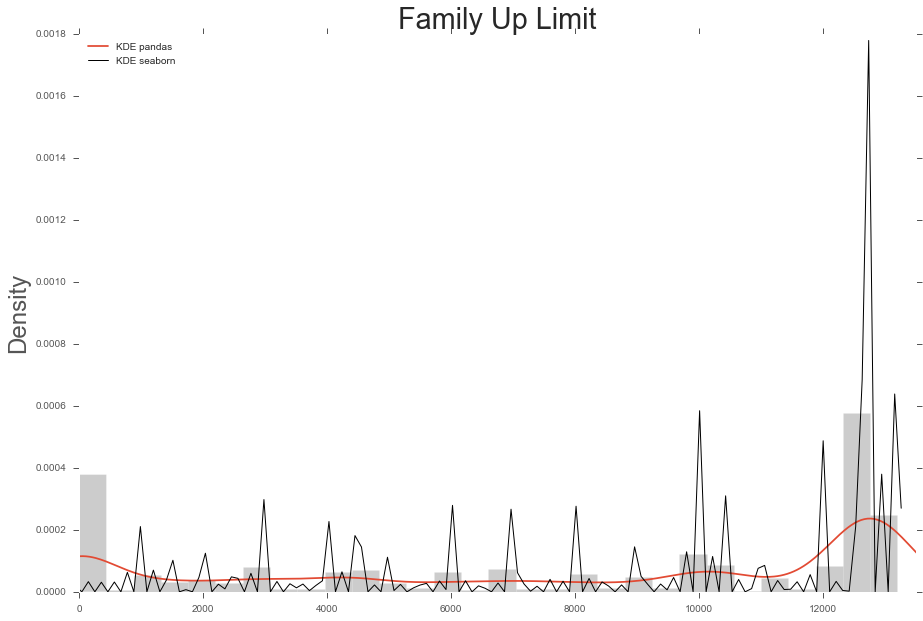

In [37]:
fig, ax = plt.subplots(figsize=(15,10))
PlanAttributesData.Family_Up_Limit.hist(bins=30, normed=True, alpha=0.4, color='grey')
PlanAttributesData.Family_Up_Limit.plot(kind='kde', title='Family Up Limit', label='KDE pandas')
sns.kdeplot(PlanAttributesData.Family_Up_Limit, bw=20, color='black', lw=1.0, label='KDE seaborn')
plt.xlim([0,13500])

#### As the KDE chart shows, lots of plan limits are 0, that means these plans are for the poor people who need help. And we can find that most limits are more than 12000, that means the U.S. insurance issurers like focusing on high-end plan products. Maybe that's why Americans usually spend loads of money on their health insurance.
#### The eye is much better at judging distances than areas, so we can find the the result easily by the CDF line's trend:

(0, 13500)

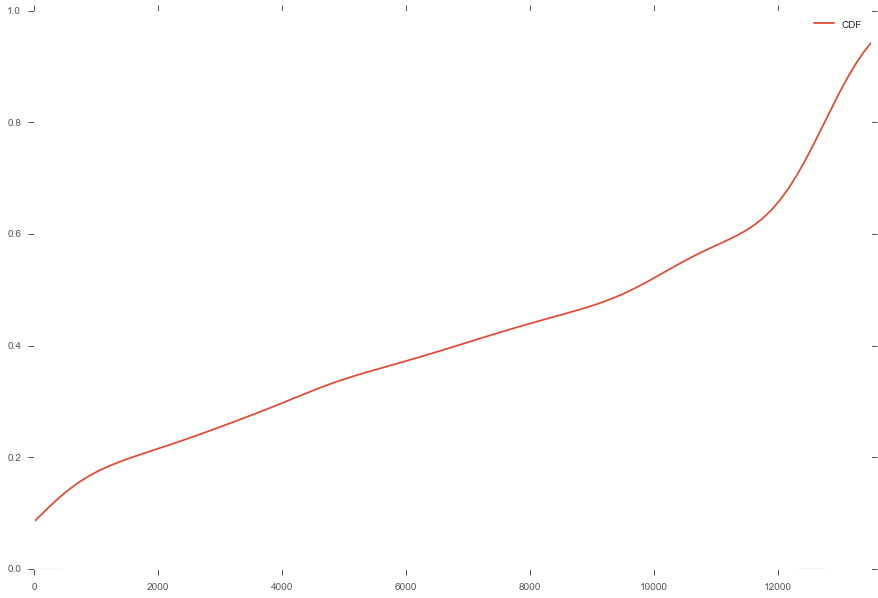

In [38]:
sns.kdeplot(PlanAttributesData.Family_Up_Limit, cumulative=True, label='CDF')
PlanAttributesData.Family_Up_Limit.hist(bins=30, normed=True, alpha=0.2, color='grey')
plt.xlim([0,13500])

### 2.2  State Rate Analysis

#### There are 50 states in America. Are the individual rates same in so many states? Check by boxplot below:

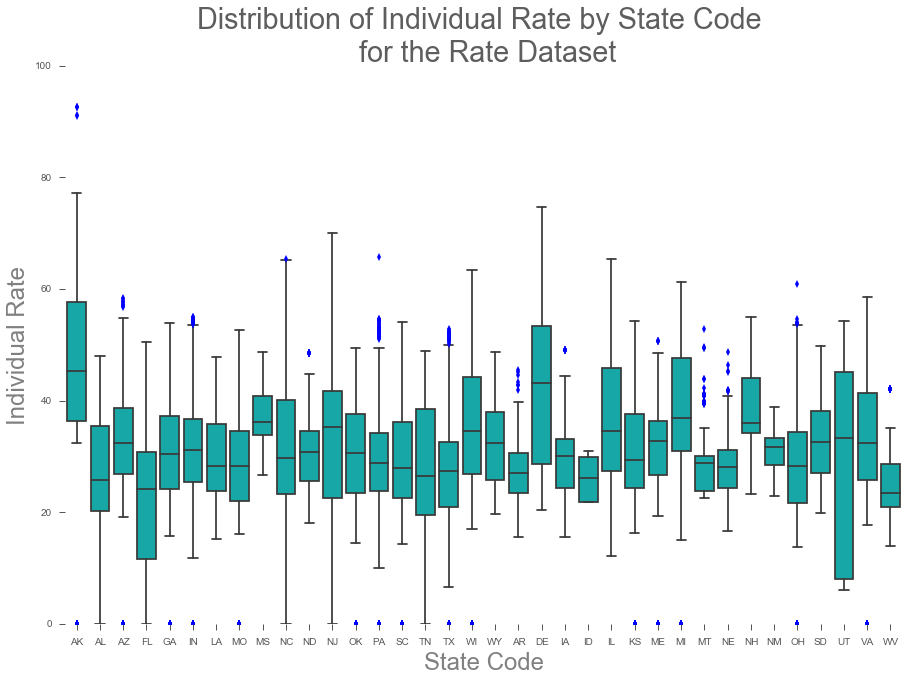

In [39]:
sns.boxplot(x="StateCode", y="IndividualRate", data=RateData_FO, color="c")

sns.despine(left=True, bottom=True)

plt.ylabel('Individual Rate', alpha=0.75)
plt.xlabel('State Code', alpha=0.75)
plt.title('Distribution of Individual Rate by State Code \n for the Rate Dataset', alpha=0.75)

#### There are big differences between the states. It's clear that the individual rates in DE, AK and MS are very high. Why is it so high? Do the people in these states have enough plan choices? Use "groupby" to coculate it below: 

D:\WinPython-64bit-2.7.10.3\python-2.7.10.amd64\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: order is deprecated, use sort_values(...)
  from ipykernel import kernelapp as app


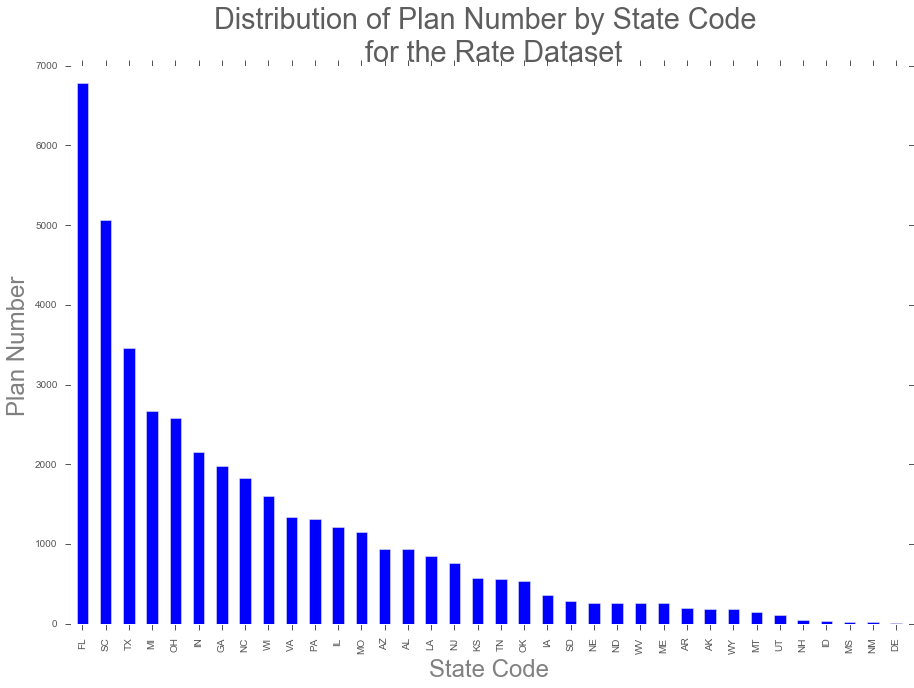

In [40]:
Plans_grouped = RateData_FO['PlanId'].groupby(RateData_FO['StateCode'])
Plans_grouped.count().order(ascending=False).plot(kind='bar')
plt.ylabel('Plan Number', alpha=0.75)
plt.xlabel('State Code', alpha=0.75)
plt.title('Distribution of Plan Number by State Code \n for the Rate Dataset', alpha=0.75)

#### The graph above shows the states where the plan offered. As It can be seen, there are fewer plan choices in DE, AK and MS states. The FL uses the plan more than the other states, so you can find the rates in this state are much cheaper. We can find why the competition is very important in the health insurance market.
----------------------

#### Calculate the median values for the rates in each states:

In [41]:
StateMedRate = RateData_FO.groupby('StateCode').median()
StateMedRate = StateMedRate.drop(StateMedRate[[0,1]],1)
StateMedRate.head(3)

,IndividualRate,Couple,CoupleAndOneDependent,CoupleAndTwoDependents,CoupleAndThreeOrMoreDependents
StateCode,,,,,
AK,45.39,78.730,132.705,154.925,160.49
AL,25.70,37.985,58.445,77.865,105.05
AR,27.02,49.465,75.230,98.720,128.11


#### And we can find the relationship between the Individual Rate and family rates:

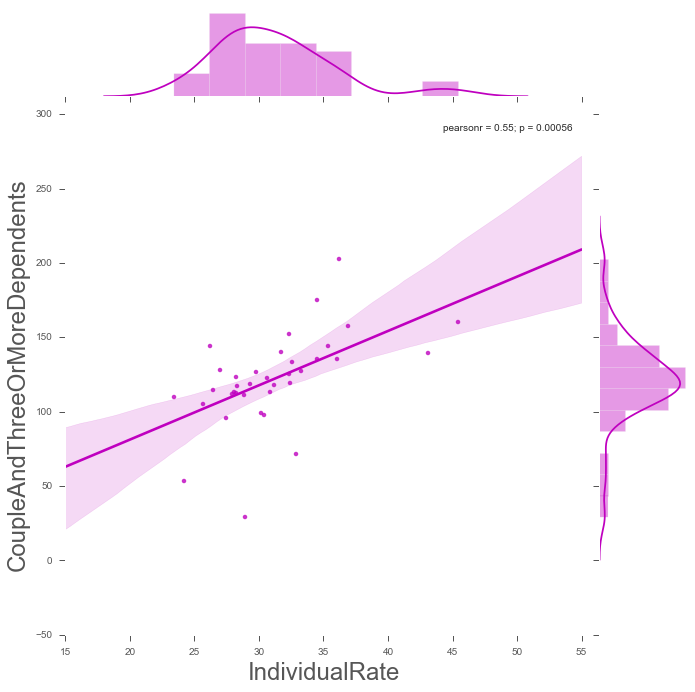

In [42]:
plt = sns.jointplot("IndividualRate", "CoupleAndThreeOrMoreDependents", data=StateMedRate, kind="reg", color="m", size=10)
sns.plt.show()

#### As can be seen from the chart above, most individual rates are around 30 and most family rates are between 100 and 150, that means health insurance is still big expense for the American parents. Find the same result from another angle:

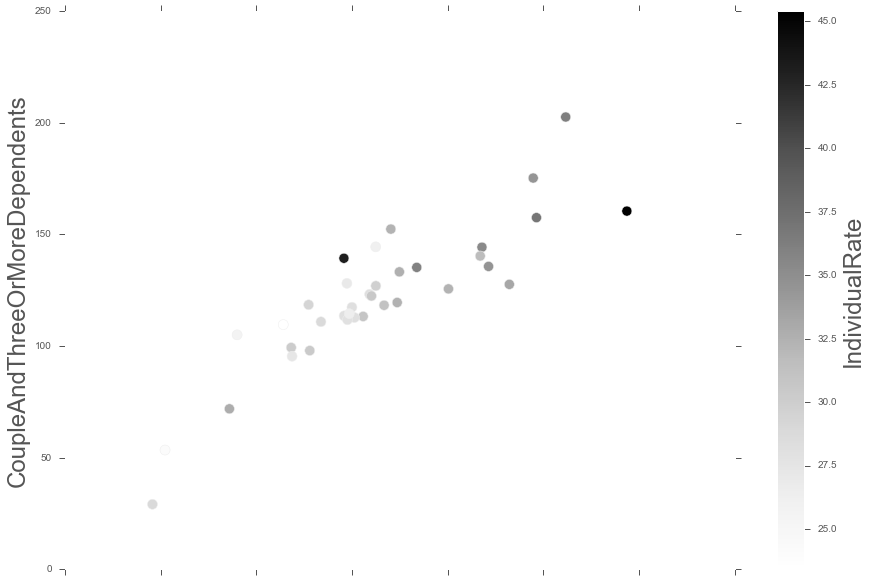

In [43]:
StateMedRate.plot(kind='scatter', x='Couple', y='CoupleAndThreeOrMoreDependents', c='IndividualRate', s=100);

## 3. Predictive Modelling

### 3.1 Predict the Couple Rate by Individual Rate (kNN)

#### Is there any clue linking the different Rates? We can try to find it by kNN. Predict the couple rate depend on Individual Rate:

In [44]:
X = StateMedRate.IndividualRate.values
X = np.reshape(X, (len(StateMedRate.IndividualRate), 1))
y = StateMedRate.Couple.values
y = np.reshape(y, (len(StateMedRate.Couple), 1))

print X.shape     
print y.shape  

(36L, 1L)
(36L, 1L)


#### Try k=5:

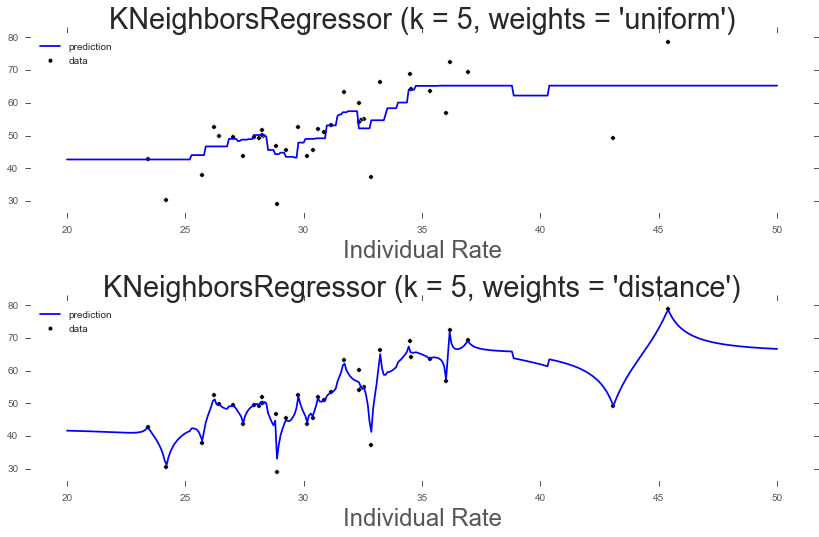

In [45]:
from sklearn import neighbors
import matplotlib.pyplot as plt

rcParams['figure.figsize'] = 14, 8

x = np.linspace(20, 50, 400)[:, np.newaxis]
n_neighbors=5

for i, weights in enumerate(['uniform', 'distance']):
    knn = neighbors.KNeighborsRegressor(n_neighbors, weights=weights)
    yp = knn.fit(X, y).predict(x)
    
    plt.subplot(2, 1, i + 1)
    plt.scatter(X, y, c='k', label='data')
    plt.plot(x, yp, c='b', label='prediction')
    plt.axis('tight')
    plt.xlabel('Individual Rate')
    plt.legend(loc='upper left')
    plt.title("KNeighborsRegressor (k = %i, weights = '%s')" % (n_neighbors, weights))
    plt.subplots_adjust( hspace=0.5)
    
plt.show()

#### Now we get the prediction about the Couple value. In this model I make k=5, but is it a good value for k? We need to coculate the best value for our prediction. First train the model and create the predicted values:

In [46]:
from sklearn import neighbors
knn = neighbors.KNeighborsRegressor(n_neighbors=5, weights='uniform')
mod = knn.fit(X, y)

In [47]:
x = np.reshape(StateMedRate.IndividualRate.values, (len(StateMedRate.IndividualRate), 1)) + 0.001
y_hat = mod.predict(x)

#### Make a definition to calculate the r square and rmse:

In [48]:
def calculate_regression_goodness_of_fit(ys, y_hat):
    ss_total = 0
    ss_residual = 0
    ss_regression = 0
    y_mean = y.mean()
    
    for i in range(len(ys)):
        ss_total += np.square(ys[i] - y_mean)
        ss_residual += np.square(ys[i] - y_hat[i])
        ss_regression += np.square(y_hat[i] - y_mean)
    
    r_square = ss_regression / ss_total
    rmse = np.sqrt( ss_residual / float(len(ys)) )
    
    return r_square[0], rmse[0]

In [49]:
calculate_regression_goodness_of_fit(y, yp)

(1.0644539669122659, 15.561268876129294)

#### Use loop to calculate the arrays:

In [50]:
rsquare_arr = []
rmse_arr = []

for k in range(2, len(y)):
    knn = neighbors.KNeighborsRegressor(n_neighbors=k)
    y_hat = knn.fit(X, y).predict(x)
    rsquare, rmse = calculate_regression_goodness_of_fit(y, y_hat)
    rmse_arr.append(rmse)
    rsquare_arr.append(rsquare)

#### Plot now:

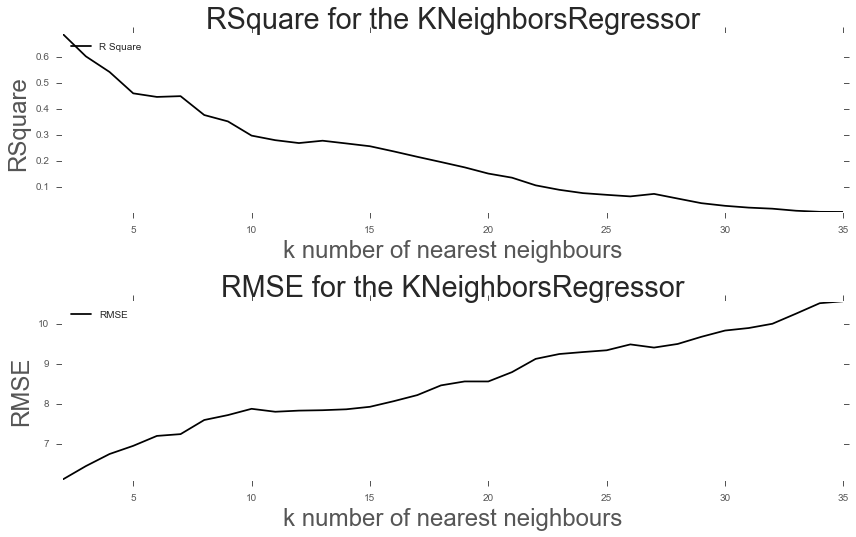

In [51]:
plt.subplot(2, 1, 1)
plt.plot(range(2, 36), rsquare_arr, c='k', label='R Square')
plt.axis('tight')
plt.xlabel('k number of nearest neighbours')
plt.ylabel('RSquare')
plt.legend(loc='upper left')
plt.title("RSquare for the KNeighborsRegressor")
plt.subplots_adjust( hspace=0.5)

plt.subplot(2, 1, 2)
plt.plot(range(2, 36), rmse_arr, c='k', label='RMSE')
plt.axis('tight')
plt.xlabel('k number of nearest neighbours')
plt.ylabel('RMSE')
plt.legend(loc='upper left')
plt.title("RMSE for the KNeighborsRegressor")

#### It's clear that 2 is the best value for k from the above plots. Use it for the predictive model:

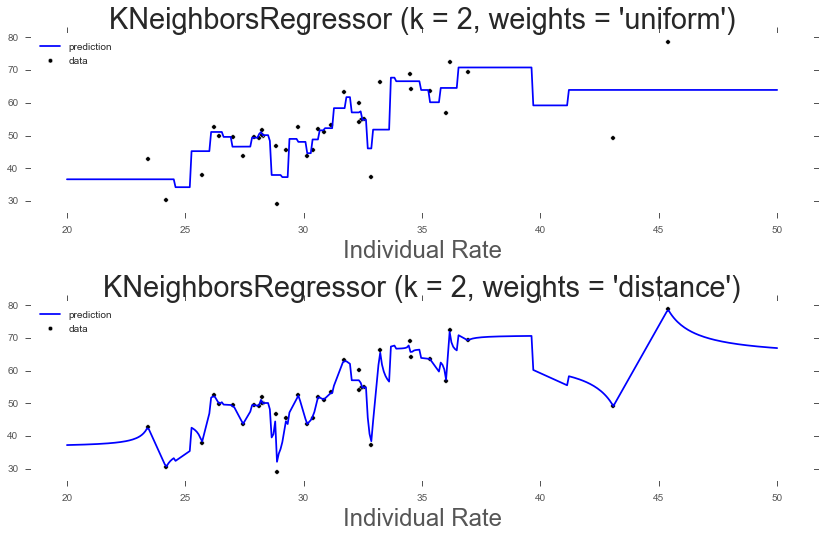

In [52]:
from sklearn import neighbors
rcParams['figure.figsize'] = 14, 8

x = np.linspace(20, 50, 400)[:, np.newaxis]
n_neighbors=2

for i, weights in enumerate(['uniform', 'distance']):
    knn = neighbors.KNeighborsRegressor(n_neighbors, weights=weights)
    yp = knn.fit(X, y).predict(x)
    
    plt.subplot(2, 1, i + 1)
    plt.scatter(X, y, c='k', label='data')
    plt.plot(x, yp, c='b', label='prediction')
    plt.axis('tight')
    plt.xlabel('Individual Rate')
    plt.legend(loc='upper left')
    plt.title("KNeighborsRegressor (k = %i, weights = '%s')" % (n_neighbors, weights))
    plt.subplots_adjust( hspace=0.5)
    
plt.show()

#### Now we get the clue linking the Individual Rates and the Couple Rates.

### 3.2 Predict State by Rates (Classification)

#### The rates of plans are different for different State. If we have a plan with five rates, can we predict which state is it most probably for? No problem, we can make it by Python.
#### First, import GaussianNB:

In [53]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()

In [54]:
RateData_FO.head(3)

,BusinessYear,StateCode,IssuerId,ImportDate,PlanId,Age,IndividualRate,Couple,CoupleAndOneDependent,CoupleAndTwoDependents,CoupleAndThreeOrMoreDependents
1,2014,AK,21989,2014-03-19 07:06:49,21989AK0020001,Family Option,36.95,73.9,144.56,144.56,144.56
2,2014,AK,21989,2014-03-19 07:06:49,21989AK0020001,Family Option,36.95,73.9,144.56,144.56,144.56
5,2014,AK,21989,2014-03-19 07:06:49,21989AK0020001,Family Option,36.95,73.9,144.56,144.56,144.56


#### Train a Naive Bayes classifier on all our training data as follows and use the model for prediction:

In [55]:
classifier = nb.fit(RateData_FO[['IndividualRate', 'Couple', 'CoupleAndOneDependent', 'CoupleAndTwoDependents', 
                        'CoupleAndThreeOrMoreDependents']], RateData_FO['StateCode'])
classifier

GaussianNB()

#### Find out how well our classifier learned the training dataset based on overall accuracy:

In [56]:
classifier.score(RateData_FO[['IndividualRate', 'Couple', 'CoupleAndOneDependent', 'CoupleAndTwoDependents', 
                        'CoupleAndThreeOrMoreDependents']], RateData_FO['StateCode'])

0.15082679954080261

#### Now we can use the classifier to classifier the state samples. First, the median rate values of the best state FL:

In [57]:
StateMedRate.ix['FL', :5]

IndividualRate                    24.19
Couple                            30.45
CoupleAndOneDependent             46.36
CoupleAndTwoDependents            49.75
CoupleAndThreeOrMoreDependents    53.44
Name: FL, dtype: float64

In [58]:
StateMedRate['Predicted State']=''
StateMedRate.ix['FL', 'Predicted State']=classifier.predict([StateMedRate.ix['FL','IndividualRate'], 
                                                              StateMedRate.ix['FL','Couple'], 
                                                              StateMedRate.ix['FL','CoupleAndOneDependent'], 
                                                              StateMedRate.ix['FL','CoupleAndTwoDependents'], 
                                                              StateMedRate.ix['FL','CoupleAndThreeOrMoreDependents']])[0]
print "This plan should be for", StateMedRate.ix['FL', 'Predicted State'], "State!"

This plan should be for FL State!


#### Get the "FL" result. Then try the worst state NM:

In [59]:
StateMedRate.ix['NM', :5]

IndividualRate                       31.7
Couple                               63.4
CoupleAndOneDependent               86.31
CoupleAndTwoDependents             108.41
CoupleAndThreeOrMoreDependents    140.375
Name: NM, dtype: object

In [60]:
StateMedRate.ix['NM', 'Predicted State']=classifier.predict([StateMedRate.ix['NM','IndividualRate'], 
                                                              StateMedRate.ix['NM','Couple'], 
                                                              StateMedRate.ix['NM','CoupleAndOneDependent'], 
                                                              StateMedRate.ix['NM','CoupleAndTwoDependents'], 
                                                              StateMedRate.ix['NM','CoupleAndThreeOrMoreDependents']])[0]
print "This plan should be for", StateMedRate.ix['NM', 'Predicted State'], "State!"

This plan should be for NM State!


#### The result is "NM"! So our Predictive model is good.

## 4. Unsupervised Learning

In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import math 
import mpld3
from sklearn import preprocessing
from sklearn import neighbors

%matplotlib inline

#### Use clustering to predict the State by rates:

In [62]:
RateData_FO.head(3)

,BusinessYear,StateCode,IssuerId,ImportDate,PlanId,Age,IndividualRate,Couple,CoupleAndOneDependent,CoupleAndTwoDependents,CoupleAndThreeOrMoreDependents
1,2014,AK,21989,2014-03-19 07:06:49,21989AK0020001,Family Option,36.95,73.9,144.56,144.56,144.56
2,2014,AK,21989,2014-03-19 07:06:49,21989AK0020001,Family Option,36.95,73.9,144.56,144.56,144.56
5,2014,AK,21989,2014-03-19 07:06:49,21989AK0020001,Family Option,36.95,73.9,144.56,144.56,144.56


#### Import KMeans:

In [63]:
from sklearn.cluster import KMeans
from sklearn import preprocessing

#### Because there are 50 states, make n_clusters = 50:

In [64]:
km = KMeans(n_clusters=50, init='random')

#### Then fit:

In [65]:
km.fit(RateData_FO[['IndividualRate', 'Couple', 'CoupleAndOneDependent', 'CoupleAndTwoDependents', 'CoupleAndThreeOrMoreDependents']].values)

KMeans(copy_x=True, init='random', max_iter=300, n_clusters=50, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

#### Get the predictions:

In [66]:
predictions = km.predict(RateData_FO[['IndividualRate', 'Couple', 'CoupleAndOneDependent', 'CoupleAndTwoDependents', 'CoupleAndThreeOrMoreDependents']].values)
predictions

array([45, 45, 45, ..., 21, 21, 21])

#### Because my computer memory is only 8G, I cannot handle the score below:

In [67]:
#from sklearn import metrics
#metrics.silhouette_score(RateData_FO[['IndividualRate', 'Couple', 'CoupleAndOneDependent', 'CoupleAndTwoDependents', 'CoupleAndThreeOrMoreDependents']], predictions)

# Summary

### The data in this report comes from CMS. After data wangling, I tried to analyse the dataset and predicted some problems. There is summery:
### 1. Used KDE and CDF to find the distribution of family out-of-pocket cost limits .
### 2. Analysed the state rates, and found that there are fewer plan choices in DE, AK and MS states, the rates of which are much more expensive. You can find why the competition is very important in the health insurance market.
### 3. Used kNN to predict the Couple Rate by Individual Rate.
### 4. Used Naive Bayes and Cluster Modelling to predict State by Rates.

# Thnak you!